In [23]:
import pandas as pd
import numpy as np
import geopandas as gpd

In [24]:
# Open crime data bases and keep first=degree homicides
crimes = pd.read_csv('data/IDM_NM_ene2020.csv', encoding = 'latin')
crimes.columns = map(str.lower, crimes.columns)

crimes.rename(columns={'año': 'year', 
                      'clave_ent': 'state_key',
                      'entidad': 'state',
                      'cve. municipio': 'key',
                      'municipio': 'municipality',
                      'bien jurídico afectado': 'affected_good',
                      'tipo de delito': 'crime_type',
                      'subtipo de delito': 'crime_subtype',
                      'modalidad': 'modality',
                      'enero': 'January',
                      'febrero': 'February',
                      'marzo' : 'March',
                      'abril': 'April',
                      'mayo': 'May',
                      'junio': 'June',
                      'julio': 'July',
                      'agosto': 'August',
                      'septiembre': 'September',
                      'octubre': 'October',
                      'noviembre': 'November',
                      'diciembre': 'December'}, inplace=True)

crimes = crimes[(crimes.crime_subtype == 'Homicidio doloso') & (crimes.year < 2020)]

crimes.drop(columns=['state_key', 'state_key', 'affected_good', 'crime_type', 'crime_subtype', 'modality'],
           inplace=True)


In [25]:
# Open old (2011-2014) crime data bases and keep first-degree homicides

crimes_old = pd.read_csv('data/IDM_oct19.csv', encoding = 'latin')
crimes_old.columns = map(str.lower, crimes_old.columns)
crimes_old = crimes_old[(crimes_old.año < 2015) & (crimes_old.modalidad == 'HOMICIDIOS') & (crimes_old.tipo == 'DOLOSOS')]

crimes_old.rename(columns={'año': 'year', 
                      'inegi': 'key',
                      'municipio': 'municipality',
                      'enero': 'January',
                      'febrero': 'February',
                      'marzo' : 'March',
                      'abril': 'April',
                      'mayo': 'May',
                      'junio': 'June',
                      'julio': 'July',
                      'agosto': 'August',
                      'septiembre': 'September',
                      'octubre': 'October',
                      'noviembre': 'November',
                      'diciembre': 'December'}, inplace=True)

crimes_old.drop(columns=['entidad', 'modalidad', 'tipo', 'subtipo', 'municipality'], inplace=True)

crimes_old=crimes_old.merge(crimes[['key', 'municipality', 'state']].drop_duplicates(), how='left', on='key')

In [26]:
# Append databases
crimes = crimes.append(crimes_old, sort=False)

# Aggregate homicides by year

crimes = crimes.melt(id_vars=['key', 'municipality', 'state', 'year'],
                   value_vars=['January', 'February', 'March', 'April', 'May', 'June',
                               'July', 'August', 'September', 'October', 'November', 'December'],
                   var_name='month', value_name='homicides')

crimes.fillna(0, inplace=True)
crimes = crimes.groupby(['key', 'municipality', 'state', 'year'], as_index=False).sum()

In [27]:
# Create columns per year
crimes = crimes.pivot_table(values='homicides', index=['key', 'municipality', 'state'], columns='year',
                            fill_value=0).reset_index()


In [28]:
# Open population estimates
pop = pd.read_csv('data/base_municipios_final_datos_01-1.csv', encoding = 'latin')
pop2 = pd.read_csv('data/base_municipios_final_datos_02-1.csv', encoding = 'latin')
pop = pop.append(pop2)

pop.columns = map(str.lower, pop.columns)

pop.rename(columns={'año': 'year', 
                    'clave': 'key',
                    }, inplace=True)

pop = pop[pop.year < 2020]

pop.drop(columns=['renglon', 'clave_ent', 'nom_ent', 'mun', 'sexo', 'edad_quin'], inplace=True)

pop = pop.groupby(['key', 'year'], as_index=False).sum()


In [29]:
# pivot population
pop['year'] = 'pop' + pop.year.apply(str)
pop = pop.pivot_table(values='pob', index='key', columns='year',
                      fill_value=0).reset_index()

In [30]:
# Get file of 2010 population Source: INEGI. Censo de Poblacon y Vivienda 2010.
pop3 = pd.read_csv('data/INEGI_Exporta_20200229165754.csv', encoding = 'latin')
pop3.key.replace('\\s', value='', regex=True, inplace=True)
pop3['key'] = pop3.key.astype(np.int64)
pop3.rename(columns={'Total': 'pop2010'}, inplace=True)
pop3.pop2010.replace('\\,', value='', regex=True, inplace=True)
pop3['pop2010'] = pop3.pop2010.astype(np.int64)
pop3.drop(columns=['mun', 'Hombre', 'Mujer'], inplace=True)
pop3 = pop3[pop3.key > 1000]

In [31]:
# Merge population data
pop = pop.merge(pop3, how='inner', on='key')

In [32]:
# Merge homicide and population data
homicides = crimes.merge(pop, how='inner', on='key')

In [33]:
# Create homicide rate variables

for y in range(2011, 2020):
    if y < 2015:
        pop = 'pop2010'

    else:
        pop = 'pop' + str(y)

    var = 'homrate' + str(y)

    homicides[var] = homicides[y] / (homicides[pop]/100000)

In [34]:
# Create region variable
homicides.loc[homicides.state == 'Coahuila de Zaragoza', 'state'] = 'Coahuila'
homicides.loc[homicides.state == 'Michoacán de Ocampo', 'state'] = 'Michoacán'
homicides.loc[homicides.state == 'Veracruz de Ignacio de la Llave', 'state'] = 'Veracruz'

nw = ['Baja California', 'Baja California Sur', 'Chihuahua', 'Sinaloa', 'Sonora']
ne = ['Coahuila', 'Durango', 'Nuevo León', 'San Luis Potosí', 'Tamaulipas']
w = ['Aguascalientes', 'Colima', 'Guanajuato', 'Jalisco', 'Michoacán', 'Nayarit', 'Querétaro', 'Zacatecas']
c = ['Ciudad de México', 'México', 'Guerrero', 'Hidalgo', 'Morelos', 'Puebla', 'Tlaxcala']
se = ['Campeche', 'Chiapas', 'Oaxaca', 'Quintana Roo', 'Tabasco', 'Veracruz', 'Yucatán']

homicides['region'] = np.where(homicides.state.isin(nw), 'Northwest',
                                np.where(homicides.state.isin(ne), 'Northeast',
                                         np.where(homicides.state.isin(w), 'West', 
                                                  np.where(homicides.state.isin(c), 'Central', 'Southeast'))))


In [35]:
# Replace Nan
homicides.fillna(0, inplace=True)

#write file
homicides.to_csv('data/homicides.csv')

In [36]:
# Open States shapefile
states = gpd.read_file('data/00ent.shp')
states.columns = map(str.lower, states.columns)

In [37]:
# Simplify geometry
states.geometry = states.geometry.simplify(tolerance=500)

# Transform crs 
states.crs = {'init' :'epsg:6362'}
states.to_crs({'init': 'epsg:4326'}, inplace=True)

/Users/eliasserrania/anaconda3/lib/python3.6/site-packages/pyproj/transformer.py:92: UserWarning: `from_crs` is deprecated and will be removed in 2.2.0. Please use `from_proj` instead.
  "`from_crs` is deprecated and will be removed in 2.2.0. "


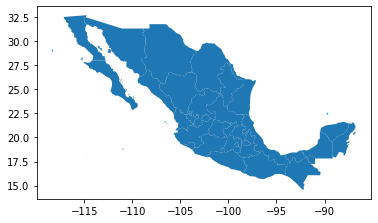

In [38]:
states.plot()

In [39]:
# Create region variable
states.loc[states.nomgeo == 'Coahuila de Zaragoza', 'nomgeo'] = 'Coahuila'
states.loc[states.nomgeo == 'Michoacán de Ocampo', 'nomgeo'] = 'Michoacán'
states.loc[states.nomgeo == 'Veracruz de Ignacio de la Llave', 'nomgeo'] = 'Veracruz'

states['region'] = np.where(states.nomgeo.isin(nw), 'Northwest',
                                np.where(states.nomgeo.isin(ne), 'Northeast',
                                         np.where(states.nomgeo.isin(w), 'West', 
                                                  np.where(states.nomgeo.isin(c), 'Central', 'Southeast'))))

In [40]:
# Write file
states.to_file('data/states.geojson', driver='GeoJSON')

In [41]:
# Open municipalites file
mun = gpd.read_file('data/00mun.shp')
mun.columns = map(str.lower, mun.columns)

In [42]:
# Change geometry for centroids
mun.geometry = mun.geometry.centroid

# Transform crs
mun.crs = {'init' :'epsg:6362'}
mun.to_crs({'init': 'epsg:4326'}, inplace=True)

/Users/eliasserrania/anaconda3/lib/python3.6/site-packages/pyproj/transformer.py:92: UserWarning: `from_crs` is deprecated and will be removed in 2.2.0. Please use `from_proj` instead.
  "`from_crs` is deprecated and will be removed in 2.2.0. "


In [43]:
# Write file
mun.to_file('data/municipalities.geojson', driver='GeoJSON')

In [44]:
test = gpd.read_file('data/states.geojson')